# Guide to preparing omnipose training data

Demonstrates the loading and splitting of the data for training purposes.

Issues:
- doesn't use correct data dir structure
- generates unwanted directories

In [ ]:
# Import required libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile
import time
import shutil
from skimage import io
import random

# Ensure omnipose is installed
try:
    import cellpose_omni
    from cellpose_omni import models, io, transforms
    from omnipose.utils import normalize99
    print("Omnipose import successful")
except ImportError:
    print("Error: Omnipose is not installed. Please install it using: pip install cellpose-omni omnipose")
    sys.exit(1)
    
# Set project paths
project_root = Path(os.getcwd())
data_dir = project_root / 'training_data'

# Create directories if they don't exist
for directory in [data_dir]:w
    directory.mkdir(exist_ok=True, parents=True)
    
print(f"Project directories initialized at: {project_root}")

2025-05-22 12:20:03,672	[INFO]     omnipose/gpu.py               <module>....()	 line  12	On ARM, OMP_NUM_THREADS set to CPU core count = 1, PARLAY_NUM_THREADS set to 1.


Omnipose import successful
Project directories initialized at: /Users/lucas/Documents/GitHub/ECT_template_1/notebooks/2_data_preprocessing


In [2]:
def organize_training_data(source_dir, train_dir, test_dir, train_ratio=0.8, balance=True, seed=42):
    """
    Organize data from source directory into train and test sets with optional balancing.
    
    Parameters:
    -----------
    source_dir : str or Path
        Directory containing image/mask pairs
    train_dir : str or Path
        Directory for training data
    test_dir : str or Path
        Directory for test data
    train_ratio : float
        Ratio of data for training (0.8 = 80% training, 20% testing)
    balance : bool
        Whether to balance data between different conditions (e.g., LB vs M9)
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    dict with counts of training and testing images per condition
    """
    source_dir = Path(source_dir)
    train_dir = Path(train_dir)
    test_dir = Path(test_dir)
    
    # Create output directories
    train_dir.mkdir(exist_ok=True, parents=True)
    test_dir.mkdir(exist_ok=True, parents=True)
    
    # Set random seed for reproducibility
    random.seed(seed)
    
    # Find all image files (excluding mask files)
    all_images = [f for f in source_dir.glob("*.tif") if not f.name.endswith("_masks.tif")]
    print(f"Found {len(all_images)} total image files")
    
    # Group images by condition (LB vs M9)
    conditions = {}
    for img in all_images:
        # Extract condition from filename (e.g., LB or M9)
        if "LB" in img.name:
            condition = "LB"
        elif "M9" in img.name:
            condition = "M9"
        else:
            condition = "other"
            
        if condition not in conditions:
            conditions[condition] = []
        conditions[condition].append(img)
    
    # Print distribution
    for condition, imgs in conditions.items():
        print(f"Condition '{condition}': {len(imgs)} images")
    
    # Balance datasets if requested
    if balance and len(conditions) > 1:
        # Find minimum count across conditions
        min_count = min(len(imgs) for imgs in conditions.values())
        print(f"Balancing datasets to {min_count} images per condition")
        
        # Subsample each condition
        for condition in conditions:
            if len(conditions[condition]) > min_count:
                conditions[condition] = random.sample(conditions[condition], min_count)
    
    # Create train/test split for each condition
    stats = {"train": {}, "test": {}}
    
    for condition, imgs in conditions.items():
        # Shuffle images
        random.shuffle(imgs)
        
        # Split into train and test
        split_idx = int(len(imgs) * train_ratio)
        train_imgs = imgs[:split_idx]
        test_imgs = imgs[split_idx:]
        
        stats["train"][condition] = len(train_imgs)
        stats["test"][condition] = len(test_imgs)
        
        print(f"Condition '{condition}': {len(train_imgs)} training, {len(test_imgs)} testing")
        
        # Copy training images and masks
        for img in train_imgs:
            mask = source_dir / f"{img.stem}_masks{img.suffix}"
            if mask.exists():
                shutil.copy(img, train_dir / img.name)
                shutil.copy(mask, train_dir / mask.name)
            else:
                print(f"Warning: No mask found for {img}")
        
        # Copy test images and masks
        for img in test_imgs:
            mask = source_dir / f"{img.stem}_masks{img.suffix}"
            if mask.exists():
                shutil.copy(img, test_dir / img.name)
                shutil.copy(mask, test_dir / mask.name)
            else:
                print(f"Warning: No mask found for {img}")
    
    # Count final files
    train_files = list(train_dir.glob("*.tif"))
    test_files = list(test_dir.glob("*.tif"))
    print(f"\nFinal dataset: {len(train_files)//2} training pairs, {len(test_files)//2} testing pairs")
    
    return stats

# Example usage:
# data_stats = organize_training_data(
#     "/path/to/your/data", 
#     data_dir / "train",
#     data_dir / "test",
#     train_ratio=0.8,
#     balance=True
# )

In [3]:
# Example usage:
data_stats = organize_training_data(
    "/Users/lucas/Documents/CellTrackML/04_Data/omnipose_training/test3", #path to the training data
    data_dir / "train",
    data_dir / "test",
    train_ratio=0.8,
    balance=True
)

Found 962 total image files
Condition 'LB': 361 images
Condition 'M9': 601 images
Balancing datasets to 361 images per condition
Condition 'LB': 288 training, 73 testing
Condition 'M9': 288 training, 73 testing

Final dataset: 576 training pairs, 146 testing pairs



=== Training Data Analysis ===
Total number of images: 576
Image size range: (432, 471) to (841, 887)
Average cell count per image: 20.4
Cell count range: 2 to 63


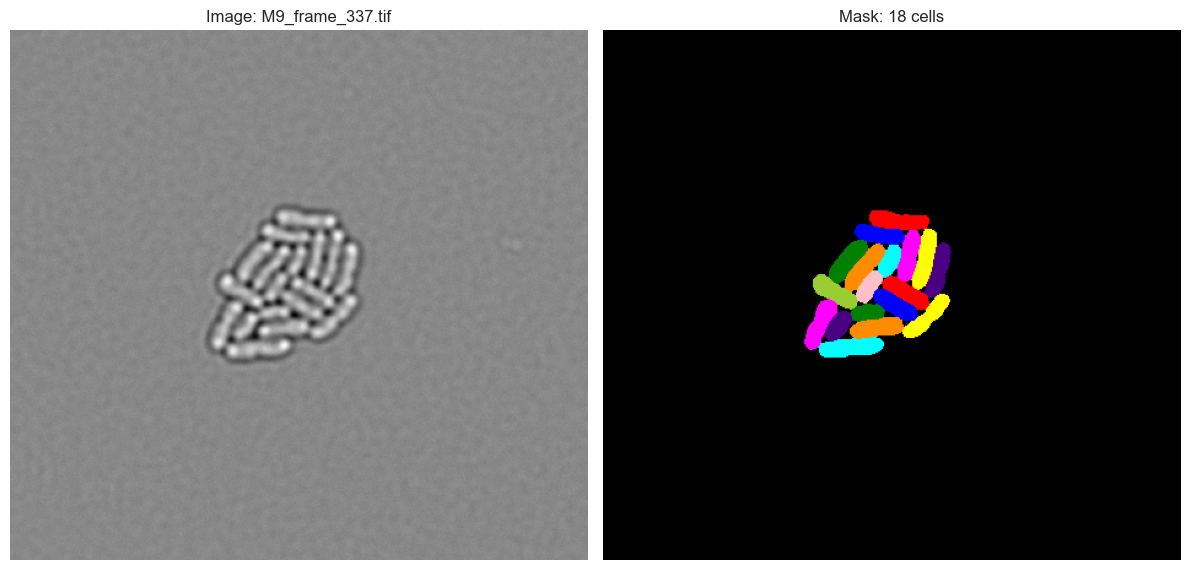

In [4]:
def analyze_training_data(data_dir):
    """Analyze training data to understand image characteristics"""
    data_dir = Path(data_dir)
    
    # Find all image/mask pairs
    images = [f for f in data_dir.glob("*.tif") if not f.name.endswith("_masks.tif")]
    
    if not images:
        print("No images found in directory!")
        return
    
    # Sample statistics
    sizes = []
    cell_counts = []
    
    # Sample up to 10 random images for statistics
    sample_imgs = random.sample(images, min(10, len(images)))
    
    for img_path in sample_imgs:
        mask_path = data_dir / f"{img_path.stem}_masks{img_path.suffix}"
        
        if not mask_path.exists():
            continue
            
        # Load image and mask
        img = tifffile.imread(img_path)
        mask = tifffile.imread(mask_path)
        
        # Collect statistics
        sizes.append(img.shape)
        cell_counts.append(len(np.unique(mask)) - 1)  # Subtract 1 for background
    
    print("\n=== Training Data Analysis ===")
    print(f"Total number of images: {len(images)}")
    print(f"Image size range: {min(sizes)} to {max(sizes)}")
    print(f"Average cell count per image: {np.mean(cell_counts):.1f}")
    print(f"Cell count range: {min(cell_counts)} to {max(cell_counts)}")
    
    # Visualize a sample
    if sample_imgs:
        img_path = sample_imgs[0]
        mask_path = data_dir / f"{img_path.stem}_masks{img_path.suffix}"
        
        if mask_path.exists():
            img = tifffile.imread(img_path)
            mask = tifffile.imread(mask_path)
            
            plt.figure(figsize=(12, 6))
            
            plt.subplot(1, 2, 1)
            plt.imshow(img, cmap='gray')
            plt.title(f"Image: {img_path.name}")
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            from skimage.color import label2rgb
            overlay = label2rgb(mask, bg_label=0)
            plt.imshow(overlay)
            plt.title(f"Mask: {len(np.unique(mask))-1} cells")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    return sizes, cell_counts

# Example usage:
sizes, cell_counts = analyze_training_data(data_dir / "train")

In [5]:
# Save data into training and test directories in data directory

# TO DO 

# Alternatively data can be moved manually into the data folders to be used in subsequent training processes.